#### Setting Up The Athena Driver

Jupyter Notebooks, like this one, provide a hybrid experience between interactive analytics and purpose built application development. You can leverage powerful statical analysis libraries like numpy or pandas and feed the results into pyplot or seaborn visualization libraries.


In [11]:
import sys
!{sys.executable} -m pip install PyAthena

In [16]:
from pyathena import connect
import pandas as pd
conn = connect(work_group='packt-athena-analytics', region_name='us-east-1', schema_name='packt_serverless_analytics')

athena_results = pd.read_sql("""SELECT year, COUNT(*) as num_rides 
                                FROM chapter_3_nyc_taxi_parquet 
                                GROUP BY year 
                                ORDER BY num_rides DESC""", conn)
athena_results.head(3)

,year,num_rides
0,2017.0,113497160
1,2018.0,102803334
2,2019.0,84397884


<AxesSubplot:xlabel='year', ylabel='num_rides'>

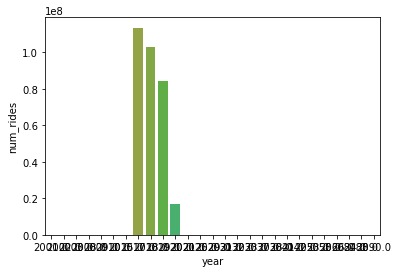

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.barplot(x="year", y="num_rides", data=athena_results)

In [18]:
from scipy import stats

#surpressing warning related to chained assignment of zscore to existing data frame
pd.options.mode.chained_assignment = None 

zscore = stats.zscore(athena_results['num_rides'])
athena_results['zscore']=zscore
print(athena_results)

      year  num_rides    zscore
0   2017.0  113497160  3.274275
1   2018.0  102803334  2.931520
2   2019.0   84397884  2.341594
3   2020.0   16847996  0.176508
4   2009.0        926 -0.363468
5   2008.0        572 -0.363480
6   2002.0         32 -0.363497
7   2003.0         19 -0.363497
8      NaN         12 -0.363497
9   2001.0         12 -0.363497
10  2084.0          8 -0.363498
11  2029.0          6 -0.363498
12  2038.0          4 -0.363498
13  2021.0          4 -0.363498
14  2026.0          3 -0.363498
15  2033.0          3 -0.363498
16  2058.0          3 -0.363498
17  2041.0          2 -0.363498
18  2088.0          2 -0.363498
19  2031.0          2 -0.363498
20  2066.0          1 -0.363498
21  2053.0          1 -0.363498
22  2090.0          1 -0.363498
23  2015.0          1 -0.363498
24  2032.0          1 -0.363498
25  2042.0          1 -0.363498
26  2037.0          1 -0.363498
27  2010.0          1 -0.363498


<AxesSubplot:xlabel='year', ylabel='num_rides'>

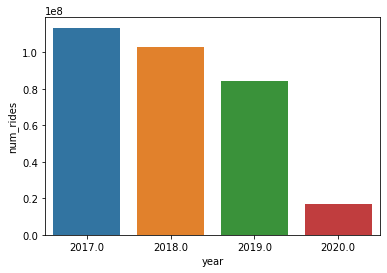

In [19]:
athena_filtered= athena_results[athena_results['zscore'] > 0]
sns.barplot(x="year", y="num_rides", data=athena_filtered)

In [24]:
athena_results_2 = pd.read_sql("""
    SELECT date_trunc('day', date_parse(tpep_pickup_datetime,'%Y-%m-%d %H:%i:%s')) as day, 
    COUNT(*) as ride_count,
    AVG(fare_amount) as avg_fare_amount,
    AVG(tip_amount) as avg_tip_amount
    FROM chapter_7_nyc_taxi_parquet 
    GROUP BY date_trunc('day', date_parse(tpep_pickup_datetime,'%Y-%m-%d %H:%i:%s'))
    ORDER BY day ASC
""", conn)

zscore2 = stats.zscore(athena_results_2['ride_count'])
athena_results_2['zscore']=zscore2
athena_filtered_2= athena_results_2[athena_results_2['zscore'] > -1]

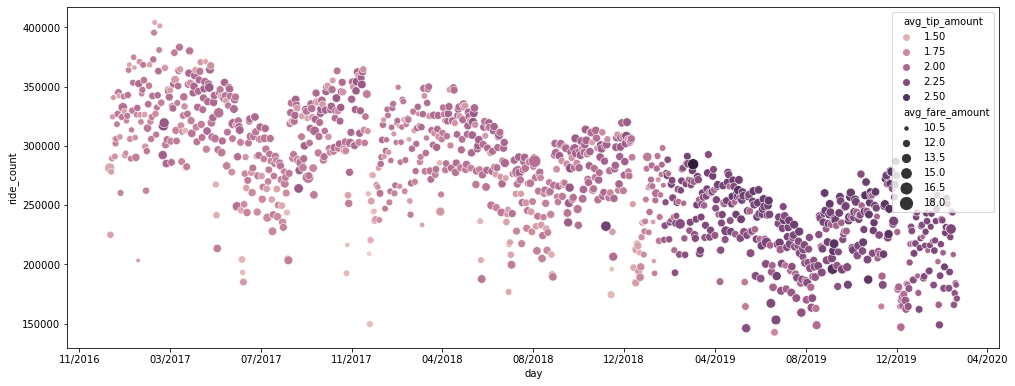

In [25]:

import matplotlib.dates as mdates
import matplotlib.ticker as ticker

fig, ax = pyplot.subplots(figsize= (16.7, 6.27))
plot = sns.scatterplot(ax=ax, x="day", y="ride_count",size="avg_fare_amount",sizes=(1, 150), hue="avg_tip_amount", data=athena_filtered_2)

plot.xaxis.set_major_locator(ticker.MultipleLocator(125))
plot.xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))

plt.show()

In [29]:
athena_results_3=pd.read_sql("""SELECT 
     max(hour(date_parse(tpep_pickup_datetime,'%Y-%m-%d %H:%i:%s'))) as hour_val, 
     avg(date_diff('second', date_parse(tpep_pickup_datetime,'%Y-%m-%d %H:%i:%s'), 
                         date_parse(tpep_dropoff_datetime,'%Y-%m-%d %H:%i:%s'))) as duration, 
     avg(trip_distance) as trip_distance,
     avg(fare_amount) as fare_amount,
     avg(tip_amount) as tip_amount,
     count(*) as cnt
from chapter_7_nyc_taxi_parquet 
WHERE year=2018
group by date_trunc('hour', date_parse(tpep_pickup_datetime,'%Y-%m-%d %H:%i:%s')) """, conn)

athena_results_3.corr()


,hour_val,duration,trip_distance,fare_amount,tip_amount,cnt
hour_val,1.000000,0.005754,-0.343937,-0.063703,0.269899,0.691085
duration,0.005754,1.000000,-0.011370,0.012235,0.019973,0.017925
trip_distance,-0.343937,-0.011370,1.000000,0.270629,0.327298,-0.721152
fare_amount,-0.063703,0.012235,0.270629,1.000000,0.210351,-0.150394
tip_amount,0.269899,0.019973,0.327298,0.210351,1.000000,0.190958
cnt,0.691085,0.017925,-0.721152,-0.150394,0.190958,1.000000
